# Monte Carlo integration (uniform and importance sampling)

Integrals (particularly in multi-dimensional space) can be difficult to solve with standard numerical integration techniques such as the trapezoidal rule. The Monte Carlo method provides an easy way out that is simple to code. The method is summarised as:

$\int f dV \approx V \langle f \rangle \pm V \sqrt{\frac{\langle f^2 \rangle-\langle f \rangle^2}{N}}$

$\langle f \rangle \equiv \frac{1}{N} \sum_{i=0}^{N-1} f(x_i)$

$\langle f^2 \rangle \equiv \frac{1}{N} \sum_{i=0}^{N-1} f^2(x_i)$

The standard method is to sample $x$ uniformly from the volume $V$. However, the variance of the estimate of the integral can be reduced if importance sampling is used. Essentially this is a change of variable and the standard uniform sampling is just a special case.

$\int f dV = \int \frac{f}{t} t\ dV \approx \langle f/t \rangle \pm \sqrt{\frac{\langle f^2/t^2 \rangle-\langle f/t \rangle^2}{N}}$

In [178]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='serif', size=80)
import pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = 8, 8

We want to integrate the Gaussian function.

In [179]:
def gauss(mu, sigma, x):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2) )

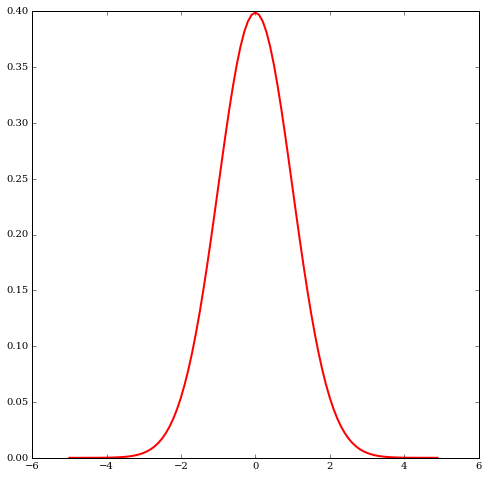

In [180]:
mu, sigma = 0, 1 # mean and standard deviation
bins = np.arange(-5, 5, 0.1)
plt.plot(bins, gauss(mu, sigma, bins), linewidth=2, color='r')

In [181]:
def uniform_sampling( a, b, N ):
    """Uniform sampling for MC integration"""
    sample = np.random.uniform(a,b,N)
    g = gauss(mu, sigma, sample)
    integral = (b-a)*np.mean(g)
    variance = (b-a)*np.sqrt( (np.mean(g*g) - (np.mean(g))**2)/N)
    return integral, variance

In [182]:
N = 10000
a = -2.5
b = +2.5
integral, variance = uniform_sampling( a, b, N )

In [183]:
print integral, variance

0.989668091355 0.00660051756761


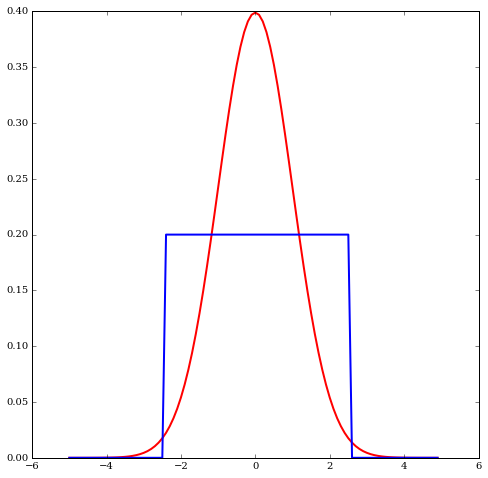

In [184]:
plt.plot(bins, gauss(mu, sigma, bins), linewidth=2, color='r')
from scipy.stats import uniform
plt.plot(bins, uniform.pdf(bins, -2.5, 5), lw=2)

In [185]:
def importance_sampling( df, N ):
    """Function to evaluate integral using MC importance sampling with a Student's t distribution"""
    sample = np.random.standard_t(df, N) # Will sample from Student's t distribution
    from scipy.stats import t
    rv = t(df) # Need this to evaluate the Student's t function
    t = rv.pdf(sample)
    g = gauss(mu, sigma, sample)
    integral = np.mean(g/t) # need to divide by the sampling distribution
    variance = np.sqrt( (np.mean((g*g)/(t*t)) - (np.mean(g/t))**2)/N )
    return integral, variance

Now lets apply this function, using a Student's t distribution with 1 degree of freedom. Look at how the integral is computed correctly and now the variance is slightly smaller than in the uniform case.

In [186]:
integral, variance = importance_sampling( 1, N )
print integral, variance

1.00587865884 0.00569969971946


Let's try again, using a Student's t distribution with 30 degrees of freedom. Look at how the integral is computed correctly and now the variance is event smaller than in the uniform case. This is because the Student's t distribution with 30 degrees of freedom much more closely resmbles the Gaussian we are interested in integrating (see the plots below).

In [187]:
integral, variance = importance_sampling( 30, N )
print integral, variance

0.999058784294 0.00054296953071


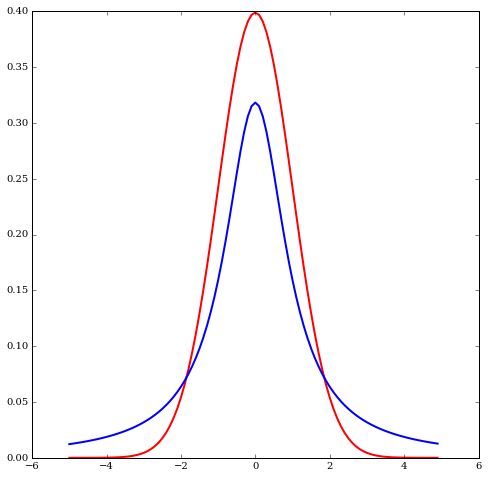

In [188]:
plt.plot(bins, gauss(mu, sigma, bins), linewidth=2, color='r')
plt.plot(bins, t.pdf(bins, 1), lw=2)

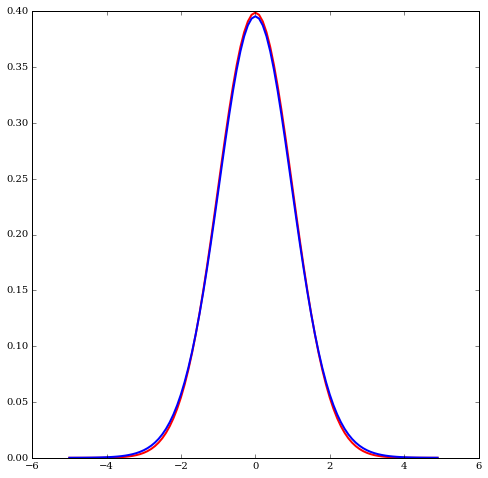

In [189]:
plt.plot(bins, gauss(mu, sigma, bins), linewidth=2, color='r')
plt.plot(bins, t.pdf(bins, 30), lw=2)

Choosing a good sampling function can be tricky (particularly in multiple dimensions). The optimal choice is something that is proportional to $|f|$, so this should be your aim. It's important that $t$ is larger than $f$ everywhere, especially in the tails. If $t$ gets smaller than $f$ then $f/t$ can blow up, which can lead to large increases in the variance.

# On uncertainties

With importance sampling the variance on the estimate of the integral is typically smaller than in the uniform sampling case, however, the variance still decreases as $\sqrt{N}$, so the more samples you have the smaller the variance becomes.

The use of quasi-random numbers (e.g., Sobol) over psuedo-random sampling can potentially lead to greater gains in un